In [1]:
import ctypes
ctypes.windll.kernel32.SetThreadExecutionState(0x80000002)
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
# non-commuter
person1 = pd.read_csv('person_commuter.csv')
act = pd.read_csv('activity_commuter.csv')
work = pd.read_csv('work_time.csv')

# commuter
# person = pd.read_csv('person_commuter.csv')
# df = pd.read_csv('df_commuter.csv')

In [2]:
act = act.merge(work, on='id', how='left')

In [3]:
act = act.merge(person1, on='id', how='left')
act['Nw'] = act['Nw'].fillna(0)
act['num_states'] = act.groupby('id')['id'].transform('count')

In [4]:
act

,id,purpose,arr_time,dep_time,gender,education,driver_license,X_transit_pass,employment,X_student,next_purpose,predicted_next_purpose,commuter,arr_time_work,dep_time_work,Nw,num_states
0,10382323,1,12,82,2,2,0,0,1,0,2,None,1,84,107,0.0,1
1,10384283,1,12,30,1,2,0,0,1,0,2,2,1,31,68,1.0,2
2,10384283,1,69,84,1,2,0,0,1,0,None,None,1,31,68,1.0,2
3,10420111,1,2,34,1,3,1,0,1,0,3,2,1,72,96,1.0,4
4,10420111,3,35,50,1,3,1,0,1,0,1,1,1,72,96,1.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9845,72115602,1,77,107,1,5,1,0,1,0,None,None,1,29,38,1.0,3
9846,72116904,1,12,26,1,1,1,0,1,0,2,2,1,27,62,1.0,2
9847,72116904,1,65,107,1,1,1,0,1,0,None,None,1,27,62,1.0,2
9848,72119712,1,12,66,1,6,1,0,1,0,2,13,1,66,72,1.0,2


In [76]:
# non-commuter
Pt = pd.read_csv('Pt_commuter.csv')
Pt = np.array(Pt['prob'])
# commuter
# Pt = pd.read_csv('Pt_commuter.csv')
# Pt = np.array(Pt['prob'])
def P1(t,Nw):
    probability = Pt[t-1]*Nw
    return probability

def P2(t,Nw,B1):
    probability = Pt[t-1]*Nw*B1
    return probability

def P3(t,Nw,B2):
    probability = Pt[t-1]*Nw*B2
    return probability

def P_home(t):
    probability = 1-Pt[t-1]/max(Pt)
    return probability

In [77]:
def simulate_day(person):
    states = ['home', 'other']
    current_state = 'home'  # 初始状态设置为home
    state_sequence = [current_state]
    num_of_trips = 0

    for t in range(1, 108):  # 对于每个时间段
        if current_state == 'home':
            # 使用P1决定是否留在home
            stay_home = np.random.rand() > P1(t,person['Nw'])
            if stay_home:
                current_state = 'home'  
            else:
                current_state = 'other'
                num_of_trips = num_of_trips + 1
        elif current_state == 'other':
            if t < 76:
                # 使用P2决定是否保持当前状态
                move = np.random.rand() < P2(t,person['Nw'],person['beta1'])
                if move:
                    # keep current state but new location
                    num_of_trips = num_of_trips + 1
                    go_other_new = np.random.rand() < P3(t,person['Nw'],person['beta2'])
                    current_state = 'other1' if go_other_new else 'home'
                else:
                    current_state = 'other' # keep current state and place
            else:
                # 当时间超过7点后，将回家的概率设置为P(O → H)和(1 −P(t)/max(P(t)))的最大值
                home = np.random.rand() < max(P2(t,person['Nw'],person['beta1']),P_home(t))   
                if home:
                    current_state = 'home'
                    num_of_trips = num_of_trips + 1
                else:
                    current_state = 'other'

        state_sequence.append(current_state)
        if current_state=='other1':
            current_state = 'other'

    return state_sequence,num_of_trips

In [78]:
act = act[act['purpose']!=1]
act['duration'] = act['dep_time'] - act['arr_time']
act

C:\Users\15123\AppData\Local\Temp\ipykernel_10668\706323788.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  act['duration'] = act['dep_time'] - act['arr_time']


,id,purpose,arr_time,dep_time,gender,education,driver_license,X_transit_pass,employment,X_student,next_purpose,predicted_next_purpose,commuter,arr_time_work,dep_time_work,Nw,num_states,duration
4,10420111,3,35,50,1,3,1,0,1,0,1,1,1,72,96,1.0,4,15
6,10420111,15,71,71,1,3,1,0,1,0,2,12,1,72,96,1.0,4,0
9,10436131,15,54,55,2,5,1,0,1,0,2,17,1,35,67,2.0,5,1
10,10436131,3,70,84,2,5,1,0,1,0,1,1,1,35,67,2.0,5,14
25,10607491,25,24,24,2,5,0,1,1,0,2,1,1,26,60,1.0,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9834,72111251,15,80,82,1,6,1,0,1,0,13,1,1,42,79,1.0,4,2
9835,72111251,13,83,83,1,6,1,0,1,0,1,1,1,42,79,1.0,4,0
9838,72113082,19,29,30,1,5,1,0,1,0,2,1,1,31,36,1.0,4,1
9839,72113082,15,67,67,1,5,1,0,1,0,1,1,1,31,36,1.0,4,0


In [79]:
act = act.rename(columns={'id': 'person'})
act

,person,purpose,arr_time,dep_time,gender,education,driver_license,X_transit_pass,employment,X_student,next_purpose,predicted_next_purpose,commuter,arr_time_work,dep_time_work,Nw,num_states,duration
4,10420111,3,35,50,1,3,1,0,1,0,1,1,1,72,96,1.0,4,15
6,10420111,15,71,71,1,3,1,0,1,0,2,12,1,72,96,1.0,4,0
9,10436131,15,54,55,2,5,1,0,1,0,2,17,1,35,67,2.0,5,1
10,10436131,3,70,84,2,5,1,0,1,0,1,1,1,35,67,2.0,5,14
25,10607491,25,24,24,2,5,0,1,1,0,2,1,1,26,60,1.0,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9834,72111251,15,80,82,1,6,1,0,1,0,13,1,1,42,79,1.0,4,2
9835,72111251,13,83,83,1,6,1,0,1,0,1,1,1,42,79,1.0,4,0
9838,72113082,19,29,30,1,5,1,0,1,0,2,1,1,31,36,1.0,4,1
9839,72113082,15,67,67,1,5,1,0,1,0,1,1,1,31,36,1.0,4,0


In [48]:
from collections import defaultdict
act['person'] = act['person'].astype(str)
# Create a dictionary to store 'states' for each 'person' in 'other' DataFrame
states_dict_other = defaultdict(list)

# Populate 'states_dict_other' with 'arr_time' and 'duration' from 'other' DataFrame
for _, row in act.iterrows():
    states_dict_other[row['person']].append([row['arr_time'], row['duration']])

# Convert the states_dict_other to a DataFrame
states_df_other = pd.DataFrame(list(states_dict_other.items()), columns=['person', 'states'])

# Merge 'states' from 'other' DataFrame to 'person' DataFrame
person = act.merge(states_df_other, on='person', how='left')
person

,person,purpose,arr_time,dep_time,gender,education,driver_license,X_transit_pass,employment,X_student,next_purpose,predicted_next_purpose,commuter,Nw,num_states,duration,states
0,10420111,3,35,50,1,3,1,0,1,0,1,1,1,1.0,4,15,"[[35, 15], [71, 0]]"
1,10420111,15,71,71,1,3,1,0,1,0,2,12,1,1.0,4,0,"[[35, 15], [71, 0]]"
2,10436131,15,54,55,2,5,1,0,1,0,2,17,1,2.0,5,1,"[[54, 1], [70, 14]]"
3,10436131,3,70,84,2,5,1,0,1,0,1,1,1,2.0,5,14,"[[54, 1], [70, 14]]"
4,10607491,25,24,24,2,5,0,1,1,0,2,1,1,1.0,3,0,"[[24, 0]]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2176,72111251,15,80,82,1,6,1,0,1,0,13,1,1,1.0,4,2,"[[80, 2], [83, 0]]"
2177,72111251,13,83,83,1,6,1,0,1,0,1,1,1,1.0,4,0,"[[80, 2], [83, 0]]"
2178,72113082,19,29,30,1,5,1,0,1,0,2,1,1,1.0,4,1,"[[29, 1], [67, 0]]"
2179,72113082,15,67,67,1,5,1,0,1,0,1,1,1,1.0,4,0,"[[29, 1], [67, 0]]"


In [34]:
person_commuter = person[person['work_tract'].notnull()]
person_non_commuter = person[person['work_tract'].isnull()]

In [49]:
# duration function
def Duration(start_time, person,beta1,beta2):
    t0 = int(start_time)
    for t in range(int(start_time), 108):  # 对于每个时间段
        if t < 76:
            # 使用P2决定是否保持当前状态
            move = np.random.rand() < P2(t, person['Nw'], beta1)
            if move:
                duration = t - t0
                return duration  # 直接返回duration作为函数结果
        else:
            # 当时间超过5点后，将回家的概率设置为P(O → H)和(1 −P(t)/max(P(t)))的最大值
            home = np.random.rand() < max(P2(t, person['Nw'], beta1), P_home(t))
            if home:
                duration = t - t0
                return duration  # 直接返回duration作为函数结果
    # 如果没有改变状态，就返回整个持续时间
    duration = 108 - t0
    return duration

In [50]:
def simulate_states(person,beta1,beta2):
    states = ['home', 'other']
    current_state = 'home'  # 初始状态设置为home
    state_sequence = [current_state]
    num_of_trips = 0

    for t in range(1, 108):  # 对于每个时间段
        if current_state == 'home':
            # 使用P1决定是否留在home
            stay_home = np.random.rand() > P1(t,person['Nw'])
            if stay_home:
                current_state = 'home'  
            else:
                current_state = 'other'
                num_of_trips = num_of_trips + 1
        elif current_state == 'other':
            if t < 76:
                # 使用P2决定是否保持当前状态
                move = np.random.rand() < P2(t,person['Nw'],beta1)
                if move:
                    # keep current state but new location
                    num_of_trips = num_of_trips + 1
                    go_other_new = np.random.rand() < P3(t,person['Nw'],beta2)
                    current_state = 'other' if go_other_new else 'home'
                else:
                    current_state = 'other' # keep current state and place
            else:
                # 当时间超过5点后，将回家的概率设置为P(O → H)和(1 −P(t)/max(P(t)))的最大值
                home = np.random.rand() < max(P2(t,person['Nw'],beta1),P_home(t))   
                if home:
                    current_state = 'home'
                    num_of_trips = num_of_trips + 1
                else:
                    current_state = 'other'

    return num_of_trips

In [51]:
# Objective function
def A(person,beta1,beta2):
    obj1,obj2 = 0,0
    states = person['states']
    for state in person['states']:
        duration_val = state[1]  # Change variable name here
        start_time = state[0]
        duration_predictions = []
        for _ in range(3):
            duration_predict = Duration(start_time, person, beta1, beta2)
            duration_predictions.append(duration_predict)
        average_duration = sum(duration_predictions) / 3
        
        obj1 += np.abs(duration_val-average_duration)

    states_val = person['num_states']
    states_predict = simulate_states(person,beta1,beta2)
    obj2 = np.abs(states_predict-1-states_val)
    obj = obj1+1.05*obj2
    return obj

In [52]:
# Beta1 and bata2 value iterations
beta1_values = list(range(1, 11))
beta2_values = list(range(1, 152, 10))

def find_best_betas(person):
    best_beta1, best_beta2 = None, None
    min_A = float('inf')
    if np.all(np.isnan(person['states'])):
        best_beta1 = 5
        best_beta2 = 90
    else:
        for beta1 in beta1_values:
            for beta2 in beta2_values:
                A_value = A(person, beta1, beta2)
                if A_value < min_A:
                    min_A = A_value
                    best_beta1 = beta1
                    best_beta2 = beta2

    return best_beta1, best_beta2

In [55]:
# 在 'df' DataFrame 中为每个 (sampno, perno) 组合计算 'lt_type' 中 'HO' 和 'WO' 的出现次数
df['HOWO_count'] = df['lt_type'].apply(lambda x: x.count('HO') + x.count('WO') + x.count('WS') + x.count('HS') if isinstance(x, str) else 0)

# 以 (sampno, perno) 组合为键，计算 'HOWO_count' 的总和，并进行向上取整
HWOS_count_dict = df.groupby(['sampno', 'perno'])['HOWO_count'].sum().apply(lambda x: np.ceil(x / 2.0)).to_dict()

# 将这个信息添加到 'new_df' DataFrame 中
person_commuter['Nw'] = person_commuter.apply(lambda row: HWOS_count_dict.get((row['sampno'], row['perno']), 0), axis=1)


In [62]:

person_commuter['num_states'] = person_commuter.apply(lambda row: row['Nw']+1 + len(row['states']) if isinstance(row['states'], list) else row['Nw']*2, axis=1)
person_commuter_commuter = person_commuter[person_commuter['Nw']==0]
person_commuter_other = person_commuter[person_commuter['Nw']>0]

In [96]:
work = work.rename(columns={'id': 'person'})
person1['person'] = person1['person'].astype(str)
work['person'] = work['person'].astype(str)
person1 = person1.merge(work, on='person', how='left')

In [105]:
person1['state_sequence']

0       [home, home, home, home, home, home, home, hom...
1       [home, home, home, home, home, home, home, hom...
2       [home, home, home, home, home, home, home, hom...
3       [home, home, home, home, home, home, home, hom...
4       [home, home, home, home, home, home, home, hom...
                              ...                        
2176    [home, home, home, home, home, home, home, hom...
2177    [home, home, home, home, home, home, home, hom...
2178    [home, home, home, home, home, home, home, hom...
2179    [home, home, home, home, home, home, home, hom...
2180    [home, home, home, home, home, home, home, hom...
Name: state_sequence, Length: 2181, dtype: object

In [106]:
person = person1.copy

In [107]:
def replace_home_with_work(row):
    arr_time_work = row['arr_time_work']
    dep_time_work = row['dep_time_work']
    state_sequence = row['state_sequence']
    return ['work' if (i >= arr_time_work and i <= dep_time_work and state == 'home') else state for i, state in enumerate(state_sequence)]

person1['state_sequence'] = person1.apply(replace_home_with_work, axis=1)

In [78]:
# 对于还有other，还要再跑一下person去生成beta
person_commuter_other

,sampno,perno,home_tract,work_tract,work_arr_time,work_dep_time,Nw,person,num_states,states
3,1038428,3,221303.0,212701.0,84.0,204.0,1.0,10384283,3.0,"[[216, 7]]"
9,1042011,1,601303.0,670003.0,216.0,0.0,2.0,10420111,5.0,"[[96, 75], [204, 3]]"
19,1045490,2,302202.0,300400.0,96.0,192.0,1.0,10454902,3.0,"[[204, 2]]"
30,1059246,1,651222.0,106520.0,96.0,156.0,1.0,10592461,4.0,"[[108, 35], [156, 6]]"
49,1067129,1,189400.0,211701.0,72.0,192.0,1.0,10671291,3.0,"[[72, 5]]"
...,...,...,...,...,...,...,...,...,...,...
16019,7188291,2,183220.0,301601.0,96.0,204.0,1.0,71882912,3.0,"[[228, 48]]"
16021,7188302,1,103200.0,190700.0,72.0,180.0,1.0,71883021,3.0,"[[228, 3]]"
16022,7188302,3,103200.0,300301.0,132.0,204.0,1.0,71883023,4.0,"[[204, 9], [228, 42]]"
16023,7188312,1,574901.0,571701.0,84.0,192.0,1.0,71883121,3.0,"[[204, 4]]"


In [86]:
from tqdm import tqdm

# Sample population
start_time = time.time()
person1 = person.copy()
person1['num_states'] = person1['num_states']


In [87]:
# Wrap the DataFrame with tqdm for a progress bar
tqdm.pandas()

# Now use progress_apply instead of apply
person1['beta1'], person1['beta2'] = zip(*person1.progress_apply(find_best_betas, axis=1))

100%|██████████████████████████████████████████████████████████████████████████████| 2181/2181 [03:44<00:00,  9.71it/s]


In [88]:
end_time = time.time()
print("Execution Time: ", end_time - start_time, "seconds")

Execution Time:  225.2504541873932 seconds


In [89]:
# Sequential prediction
person1['beta1'].mean()

6.0499770747363595

In [99]:
start_time = time.time()
results = person1.apply(simulate_day, axis=1)
person1['state_sequence'] = results.apply(lambda x: x[0])
person1['num_of_trips'] = results.apply(lambda x: x[1])
end_time = time.time()
print("Execution Time: ", end_time - start_time, "seconds")

Execution Time:  0.9121336936950684 seconds


In [100]:
person1

,person,purpose,arr_time,dep_time,gender,education,driver_license,X_transit_pass,employment,X_student,...,Nw,num_states,duration,states,beta1,beta2,state_sequence,num_of_trips,arr_time_work,dep_time_work
0,10420111,3,35,50,1,3,1,0,1,0,...,1.0,4,15,"[[35, 15], [71, 0]]",7,121,"[home, home, home, home, home, home, home, hom...",3,72,96
1,10420111,15,71,71,1,3,1,0,1,0,...,1.0,4,0,"[[35, 15], [71, 0]]",9,111,"[home, home, home, home, home, home, home, hom...",6,72,96
2,10436131,15,54,55,2,5,1,0,1,0,...,2.0,5,1,"[[54, 1], [70, 14]]",3,11,"[home, home, home, home, home, home, home, hom...",2,35,67
3,10436131,3,70,84,2,5,1,0,1,0,...,2.0,5,14,"[[54, 1], [70, 14]]",6,1,"[home, home, home, home, home, home, home, hom...",0,35,67
4,10607491,25,24,24,2,5,0,1,1,0,...,1.0,3,0,"[[24, 0]]",7,1,"[home, home, home, home, home, home, home, hom...",2,26,60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2176,72111251,15,80,82,1,6,1,0,1,0,...,1.0,4,2,"[[80, 2], [83, 0]]",6,41,"[home, home, home, home, home, home, home, hom...",2,42,79
2177,72111251,13,83,83,1,6,1,0,1,0,...,1.0,4,0,"[[80, 2], [83, 0]]",7,141,"[home, home, home, home, home, home, home, hom...",6,42,79
2178,72113082,19,29,30,1,5,1,0,1,0,...,1.0,4,1,"[[29, 1], [67, 0]]",6,91,"[home, home, home, home, home, home, home, hom...",3,31,36
2179,72113082,15,67,67,1,5,1,0,1,0,...,1.0,4,0,"[[29, 1], [67, 0]]",10,21,"[home, home, home, home, home, home, home, hom...",2,31,36


In [109]:
person1.to_csv('act_commuters.csv')

In [ ]:
person1

FileNotFoundError: [Errno 2] No such file or directory: './output/Distribution of Duration.png'

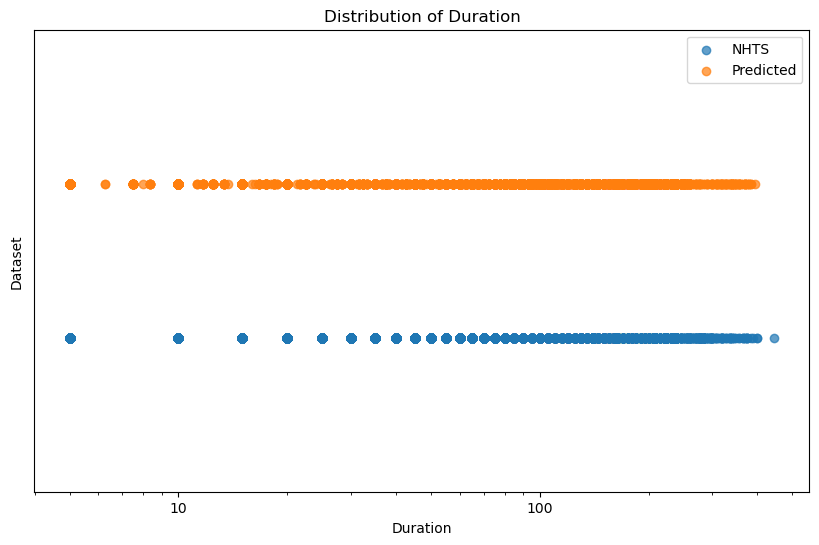

In [28]:
import matplotlib.ticker as ticker

def count_segments(row):
    state_sequence = row['state_sequence']
    segment_count = 0
    count_home = 0
    for state in state_sequence:
        if state == 'home':
            count_home += 1
        elif count_home > 0 and (state == 'other' or state == 'other1'):
            segment_count += 1
            count_home = 0
    return segment_count

# Filter out negative values from NHTS duration
nhts_duration = person1['states'].apply(lambda x: x[0][1]*5)
nhts_duration = nhts_duration[nhts_duration >= 0]

# Calculate the duration for predicted dataset
predicted_duration = person1.apply(lambda row: 5*(row['state_sequence'].count('other') / count_segments(row)) if count_segments(row) > 0 else 0, axis=1)
predicted_duration = predicted_duration[predicted_duration!=0]
# Determine the common bin range for both datasets
bin_range = (min(nhts_duration.min(), predicted_duration.min()), max(nhts_duration.max(), predicted_duration.max()))

# Create a new figure
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the scatter plot for NHTS duration
ax.scatter(nhts_duration, [1]*len(nhts_duration), marker='o', label='NHTS', alpha=0.7)

# Plot the scatter plot for predicted duration
ax.scatter(predicted_duration, [2]*len(predicted_duration), marker='o', label='Predicted', alpha=0.7)

# Set y-axis limits
ax.set_ylim([0, 3])

# Set labels and title
ax.set_xlabel('Duration')
ax.set_ylabel('Dataset')
ax.set_title('Distribution of Duration')

# Show the legend
ax.legend()

# Set x-axis scale to logarithmic
ax.set_xscale('log')
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())

# Remove y-axis ticks and labels
ax.set_yticks([])
ax.set_yticklabels([])
plt.savefig('./output/Distribution of Duration.png')
# Show the plot
plt.show()


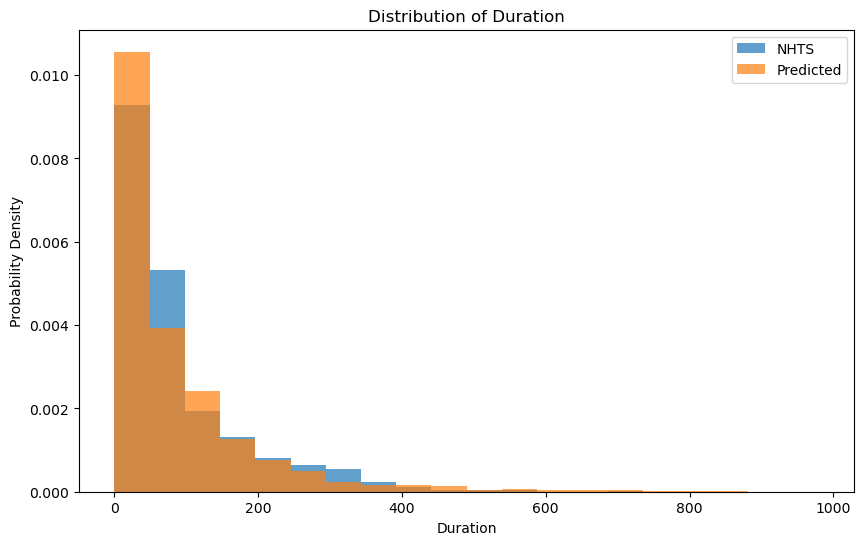

In [95]:
import matplotlib.pyplot as plt

def count_segments(row):
    state_sequence = row['state_sequence']
    segment_count = 0
    count_home = 0
    for state in state_sequence:
        if state == 'home':
            count_home += 1
        elif count_home > 0 and state == 'other':
            segment_count += 1
            count_home = 0
        if state == 'other1':
            segment_count += 1
    return segment_count

nhts_duration = person1['states'].apply(lambda x: [state[1] * 5 for state in x])
nhts_duration = nhts_duration.explode().reset_index(drop=True)

# Calculate the duration for predicted dataset
predicted_duration = person1.apply(lambda row: 5*(row['state_sequence'].count('other') / count_segments(row)) if count_segments(row) > 0 else 0, axis=1)

# Determine the common bin range for both datasets
bin_range = (min(nhts_duration.min(), predicted_duration.min()), max(nhts_duration.max(), predicted_duration.max()))

# Create a new figure
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the histogram for NHTS duration
ax.hist(nhts_duration, bins=20, range=bin_range, alpha=0.7, label='NHTS', density=True)

# Plot the histogram for predicted duration
ax.hist(predicted_duration, bins=20, range=bin_range, alpha=0.7, label='Predicted', density=True)

# Set labels and title
ax.set_xlabel('Duration')
ax.set_ylabel('Probability Density')
ax.set_title('Distribution of Duration')

# Show the legend
ax.legend()
plt.savefig('./output/duration.png')
# Show the plot
plt.show()


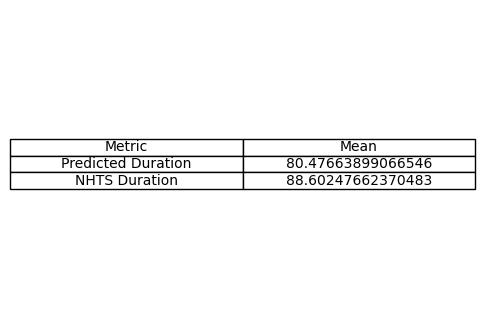

In [96]:
data = {
    'Metric': ['Predicted Duration', 'NHTS Duration'],
    'Mean': [predicted_duration.mean(), nhts_duration.mean()]
}
df = pd.DataFrame(data)

# Create the table visualization
fig, ax = plt.subplots(figsize=(6, 4))  # Adjust the figsize as needed
ax.axis('off')  # Hide the axes
ax.table(cellText=df.values, colLabels=df.columns, cellLoc='center', loc='center')

# Save the table as an image
plt.savefig('./output/table_image.png', bbox_inches='tight')

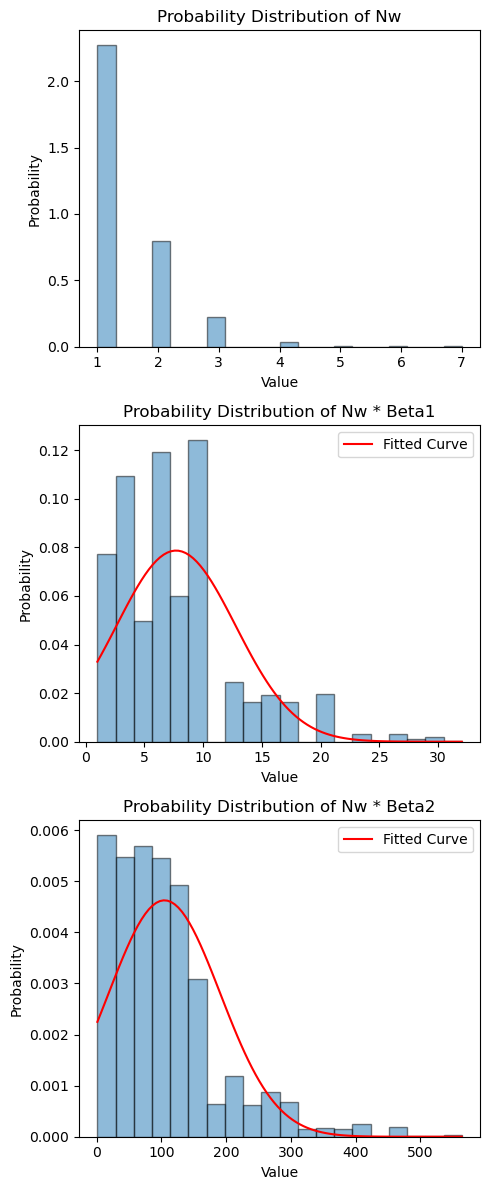

In [97]:
# Create a new figure with three subplots
fig, axes = plt.subplots(3, 1, figsize=(5, 12))

# Plot the histogram of 'Nw' in the first subplot
axes[0].hist(person1['Nw'], bins=20, density=True, alpha=0.5, edgecolor='black')
axes[0].set_xlabel('Value')
axes[0].set_ylabel('Probability')
axes[0].set_title('Probability Distribution of Nw')

# Calculate the product of 'Nw' and 'beta1'
product1 = person1['Nw'] * person1['beta1']

# Plot the histogram of the product1 in the second subplot
axes[1].hist(product1, bins=20, density=True, alpha=0.5, edgecolor='black')
axes[1].set_xlabel('Value')
axes[1].set_ylabel('Probability')
axes[1].set_title('Probability Distribution of Nw * Beta1')

# Fit a distribution and plot the fitted curve for product1
mu, sigma = stats.norm.fit(product1)
x = np.linspace(product1.min(), product1.max(), 100)
y = stats.norm.pdf(x, mu, sigma)
axes[1].plot(x, y, 'r-', label='Fitted Curve')

# Calculate the product of 'Nw' and 'beta2'
product2 = person1['Nw'] * person1['beta2']

# Plot the histogram of the product2 in the third subplot
axes[2].hist(product2, bins=20, density=True, alpha=0.5, edgecolor='black')
axes[2].set_xlabel('Value')
axes[2].set_ylabel('Probability')
axes[2].set_title('Probability Distribution of Nw * Beta2')

# Fit a distribution and plot the fitted curve for product2
mu, sigma = stats.norm.fit(product2)
x = np.linspace(product2.min(), product2.max(), 100)
y = stats.norm.pdf(x, mu, sigma)
axes[2].plot(x, y, 'r-', label='Fitted Curve')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the legends
axes[1].legend()
axes[2].legend()
plt.savefig('./output/Nw,Betas.png')
# Show the plot
plt.show()

3.4845953002610965 4.484073107049609


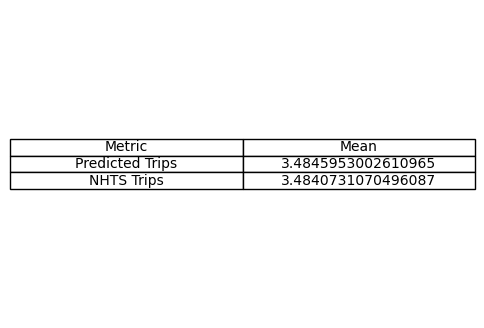

In [98]:
data = {
    'Metric': ['Predicted Trips', 'NHTS Trips'],
    'Mean': [person1['num_of_trips'].mean(), person1['num_states'].mean()-1]
}
df = pd.DataFrame(data)

# Create the table visualization
fig, ax = plt.subplots(figsize=(6, 4))  # Adjust the figsize as needed
ax.axis('off')  # Hide the axes
ax.table(cellText=df.values, colLabels=df.columns, cellLoc='center', loc='center')

# Save the table as an image
plt.savefig('./output/Average trip numbers.png', bbox_inches='tight')

print(person1['num_of_trips'].mean(),person1['num_states'].mean())

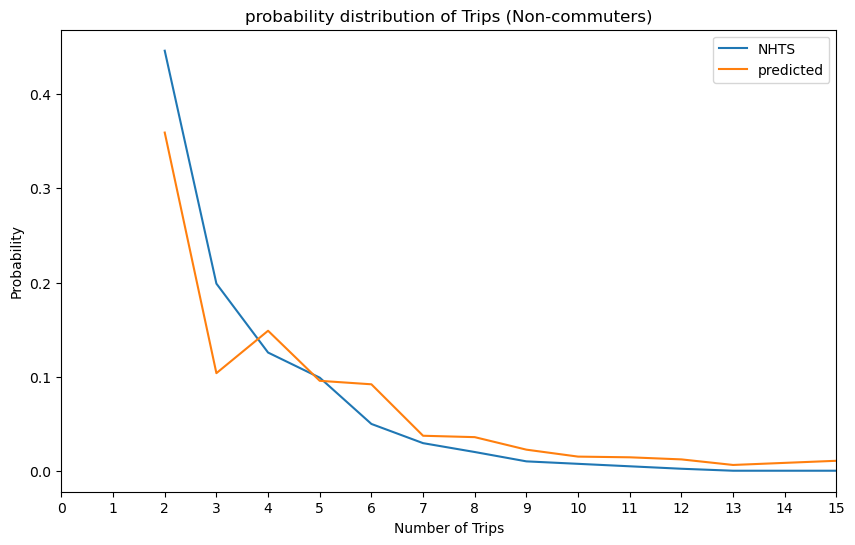

In [99]:
# Calculate value counts
num_states_counts = (person1['num_states']-1).value_counts().sort_index()/len(person1)
num_of_trips_counts = person1['num_of_trips'].value_counts().sort_index()/len(person1[person1['num_of_trips']!=0])
num_of_trips_counts = num_of_trips_counts.drop(0)
# Create a new figure
plt.figure(figsize=(10, 6))

# Plot value counts
sns.lineplot(x=num_states_counts.index, y=num_states_counts.values, label='NHTS')
sns.lineplot(x=list(num_of_trips_counts.index), y=list(num_of_trips_counts.values), label='predicted')

# Set labels and title
plt.xlabel('Number of Trips')
plt.ylabel('Probability')
plt.title('probability distribution of Trips (Non-commuters)')
plt.legend()
# Set x-axis limits
plt.xlim([0, 15])
# Ensure only integers are displayed on the x-axis
plt.xticks(range(0, 16))
plt.savefig('./output/probability distribution of Trips (Non-commuters).png')
# Show the plot
plt.show()


In [115]:
def update_state_sequence(row):
    for i in range(int(row['work_arr_time']), int(row['work_dep_time'])):
        if row['state_sequence'][i] == 'home':
            row['state_sequence'][i] = 'work'
    return row['state_sequence']

person1.loc[person1['work_dep_time'] == 0, 'work_dep_time'] = 288
person1['state_sequence'] = person1.apply(update_state_sequence, axis=1)

In [116]:
combined_df = pd.concat([person1, person_commuter_commuter], axis=0, ignore_index=True)
combined_df

,sampno,perno,home_tract,work_tract,work_arr_time,work_dep_time,Nw,person,num_states,states,beta1,beta2,state_sequence,num_of_trips
0,1038428,3,221303.0,212701.0,84.0,204.0,1.0,10384283,3.0,"[[216, 7]]",7.0,81.0,"[home, home, home, home, home, home, home, hom...",0.0
1,1042011,1,601303.0,670003.0,216.0,288.0,2.0,10420111,5.0,"[[96, 75], [204, 3]]",1.0,101.0,"[home, home, home, home, home, home, home, hom...",2.0
2,1045490,2,302202.0,300400.0,96.0,192.0,1.0,10454902,3.0,"[[204, 2]]",10.0,51.0,"[home, home, home, home, home, home, home, hom...",3.0
3,1059246,1,651222.0,106520.0,96.0,156.0,1.0,10592461,4.0,"[[108, 35], [156, 6]]",8.0,111.0,"[home, home, home, home, home, home, home, hom...",5.0
4,1067129,1,189400.0,211701.0,72.0,192.0,1.0,10671291,3.0,"[[72, 5]]",6.0,111.0,"[home, home, home, home, home, home, home, hom...",2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3970,7188114,2,277000.0,574601.0,108.0,216.0,0.0,71881142,0.0,NaN,NaN,NaN,"[home, home, home, home, home, home, home, hom...",NaN
3971,7188280,2,460100.0,460501.0,96.0,192.0,0.0,71882802,0.0,NaN,NaN,NaN,"[home, home, home, home, home, home, home, hom...",NaN
3972,7188295,1,264302.0,134306.0,96.0,216.0,0.0,71882951,0.0,NaN,NaN,NaN,"[home, home, home, home, home, home, home, hom...",NaN
3973,7188344,1,571102.0,554512.0,84.0,228.0,0.0,71883441,0.0,NaN,NaN,NaN,"[home, home, home, home, home, home, home, hom...",NaN


In [117]:
combined_df.to_csv('./output/person.csv',index=False)